# Mapas Autoorganizados de Kohonen (SOM)

Los Mapas Autoorganizados de Kohonen (SOM) son una técnica de aprendizaje no supervisado que proyecta datos de alta dimensionalidad en un espacio de menor dimensión (generalmente 2D), preservando la topología de los datos originales. Esto significa que puntos similares en el espacio original estarán cercanos en el mapa resultante. Los SOM son especialmente útiles para la visualización y el análisis exploratorio de datos multidimensionales.

## 1. Preparación del Dataset

Comenzaremos preparando el dataset de manera similar pero adaptándolo para el SOM.

In [30]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilos de visualización
sns.set(style="whitegrid")
%matplotlib inline

# Carga del dataset (asegúrate de que no haya valores faltantes)
df = pd.read_csv('movie_data.csv', sep=';').dropna()

# Transformación de 'release_date' a tipo datetime y extracción del año
df['release_date'] = pd.to_datetime(df['release_date'], format='%Y-%m-%d')
df['release_year'] = df['release_date'].dt.year

# Selección de variables numéricas relevantes
numerical_features = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']

# Selección del dataset de muestra (10% del total)
df_sample = df.sample(frac=0.1, random_state=42)

# Extracción de las características seleccionadas
X = df_sample[numerical_features].values

# Escalado de las variables
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Verificación de las primeras filas escaladas
print("\nPrimeras filas del conjunto de datos escalado:")
print(pd.DataFrame(X_scaled, columns=numerical_features).head())


Primeras filas del conjunto de datos escalado:
   budget  popularity   revenue   runtime  vote_average  vote_count
0  0.4600    0.546542  0.532935  0.168831      0.882353    0.597261
1  0.0320    0.191370  0.007342  0.207792      0.670588    0.015733
2  0.0400    0.111814  0.017013  0.214286      0.541176    0.005827
3  0.0068    0.042582  0.000000  0.155844      0.670588    0.001165
4  0.0420    0.095898  0.010956  0.149351      0.529412    0.005050


In [31]:
print(len(X_scaled))

498


## 2. Implementación de la Red de Kohonen desde Cero

Definimos una clase `SOM` que contendrá todos los métodos necesarios.

In [32]:
# Function to calculate the U-matrix
def calculate_u_matrix(som):
    u_matrix = np.zeros((som.m, som.n))
    weights = som.weights
    for i in range(som.m):
        for j in range(som.n):
            # Get the vector at position (i,j)
            vec = weights[i, j]
            # List to hold the distances to the neighbors
            neighbor_dists = []
            # Check for neighboring neurons and calculate the distances
            if i > 0:
                neighbor_dists.append(np.linalg.norm(vec - weights[i - 1, j]))
            if i < som.m - 1:
                neighbor_dists.append(np.linalg.norm(vec - weights[i + 1, j]))
            if j > 0:
                neighbor_dists.append(np.linalg.norm(vec - weights[i, j - 1]))
            if j < som.n - 1:
                neighbor_dists.append(np.linalg.norm(vec - weights[i, j + 1]))
            # Calculate the average distance to neighbors
            u_matrix[i, j] = np.mean(neighbor_dists)
    return u_matrix

In [33]:
# Step 3: Implementing the SOM class from scratch

class SOM:
    def __init__(self, m, n, dim, sigma=None, learning_rate=0.5, num_iterations=10000):
        """
        Initializes the SOM.

        Parameters:
        - m, n: dimensions of the SOM grid (rows, columns).
        - dim: dimensionality of the input data.
        - sigma: initial neighborhood radius.
        - learning_rate: initial learning rate.
        - num_iterations: number of iterations for training.
        """
        self.m = m
        self.n = n
        self.dim = dim
        if sigma is None:
            sigma = max(m, n) / 2.0  # Typically set to half of the grid size
        self.sigma = sigma
        self.initial_sigma = sigma
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = np.random.rand(m, n, dim)

        # Coordinates of all neurons in the grid
        self.neuron_locations = np.array(list(self._neuron_locations()))

    def _neuron_locations(self):
        """Generates the coordinates of the neurons in the grid."""
        for i in range(self.m):
            for j in range(self.n):
                yield np.array([i, j])

    def _decay_sigma(self, iteration):
        """Updates the sigma value."""
        return self.initial_sigma * np.exp(-iteration / self.num_iterations)

    def _decay_learning_rate(self, iteration):
        """Updates the learning rate."""
        return self.initial_learning_rate * np.exp(-iteration / self.num_iterations)

    def _neighborhood_function(self, distance, sigma):
        """Calculates the neighborhood function (Gaussian)."""
        return np.exp(-distance ** 2 / (2 * sigma ** 2))

    def _find_bmu(self, x):
        """Finds the Best Matching Unit (BMU) for a given sample x."""
        distances = np.linalg.norm(self.weights - x, axis=2)
        bmu_index = np.unravel_index(np.argmin(distances), (self.m, self.n))
        return bmu_index

    def _update_weights(self, x, bmu, iteration):
        """Updates the weights of the neurons."""
        # Decay sigma and learning rate
        sigma = self._decay_sigma(iteration)
        learning_rate = self._decay_learning_rate(iteration)

        # Compute the distance from the BMU to all other neurons
        bmu_location = np.array(bmu)
        distances = np.linalg.norm(self.neuron_locations - bmu_location, axis=1)

        # Compute the neighborhood function
        neighborhood = self._neighborhood_function(distances, sigma)

        # Update the weights
        neighborhood = neighborhood[:, np.newaxis]
        delta = learning_rate * neighborhood * (x - self.weights.reshape(self.m * self.n, self.dim))
        self.weights += delta.reshape(self.m, self.n, self.dim)

    def train(self, data, capture_interval=None):
        """Trains the SOM with the provided data.

        Parameters:
        - data: Input data to train on.
        - capture_interval: If provided, captures the U-matrix at specified intervals for visualization.
        """
        if capture_interval is not None:
            self.u_matrices = []  # To store U-matrices
        for iteration in range(self.num_iterations):
            # Randomly select a sample
            x = data[np.random.randint(0, data.shape[0])]
            # Find the BMU
            bmu = self._find_bmu(x)
            # Update the weights
            self._update_weights(x, bmu, iteration)
            # Capture the U-matrix at intervals
            if capture_interval is not None and ((iteration + 1) % capture_interval == 0 or iteration == 0):
                u_matrix = calculate_u_matrix(self)
                self.u_matrices.append(u_matrix)

    def map_vects(self, data):
        """Maps each sample to a position on the map."""
        mapped = []
        for x in data:
            bmu = self._find_bmu(x)
            mapped.append(bmu)
        return mapped


## 3. Entrenamiento

Determinamos el tamaño del mapa y entrenamos el SOM.

In [34]:
# Calculate the size of the SOM grid (you can adjust m and n as needed)
#m = n = int(np.ceil(5 * np.sqrt(np.sqrt(X_scaled.shape[0]))))
m = n = int(np.ceil(np.sqrt(5 * np.sqrt(X_scaled.shape[0]))))
print(f"SOM grid size: {m}x{n}")

# Define the number of iterations and the capture interval
num_iterations = 249000
capture_interval = 500  # Capture every 500 iterations

# Initialize and train the SOM with capture of U-matrices
som = SOM(m=m, n=n, dim=X_scaled.shape[1], sigma=m, learning_rate=0.1, num_iterations=num_iterations)
som.train(X_scaled, capture_interval=capture_interval)

print("Training completed.")


SOM grid size: 11x11


Training completed.


## 4. Visualización del Mapa U

El Mapa U muestra las distancias entre los pesos de las neuronas vecinas.

ValueError: 'Grey' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

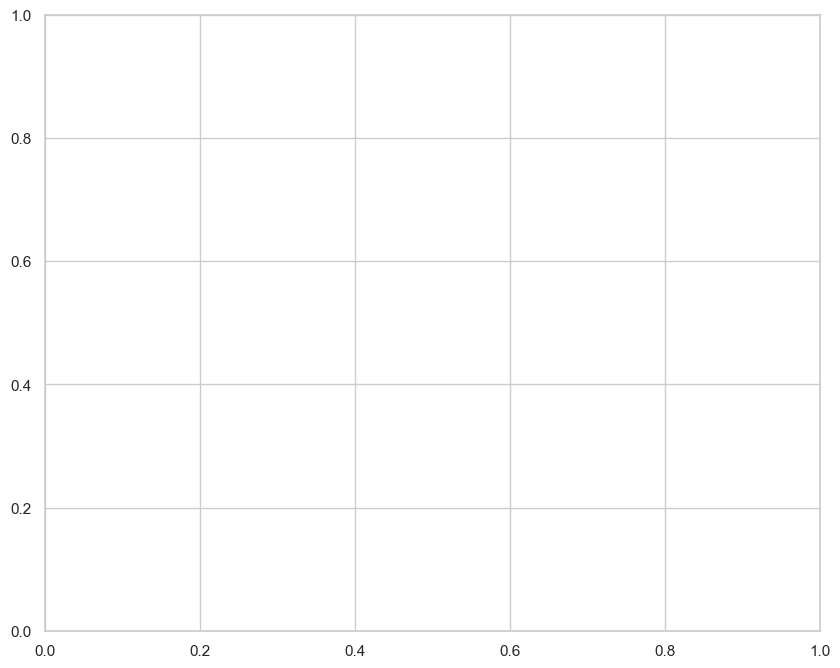

In [37]:
# Calcular el Mapa U final
u_matrix = calculate_u_matrix(som)

# Visualizar el Mapa U
plt.figure(figsize=(10, 8))
plt.imshow(u_matrix, cmap='Grey')
plt.colorbar()
plt.title('Mapa U (Unified Distance Matrix)')
plt.show()

## 5. Visualización de las Muestras en el Mapa SOM

Asignamos cada muestra a su BMU y visualizamos las posiciones en el mapa.

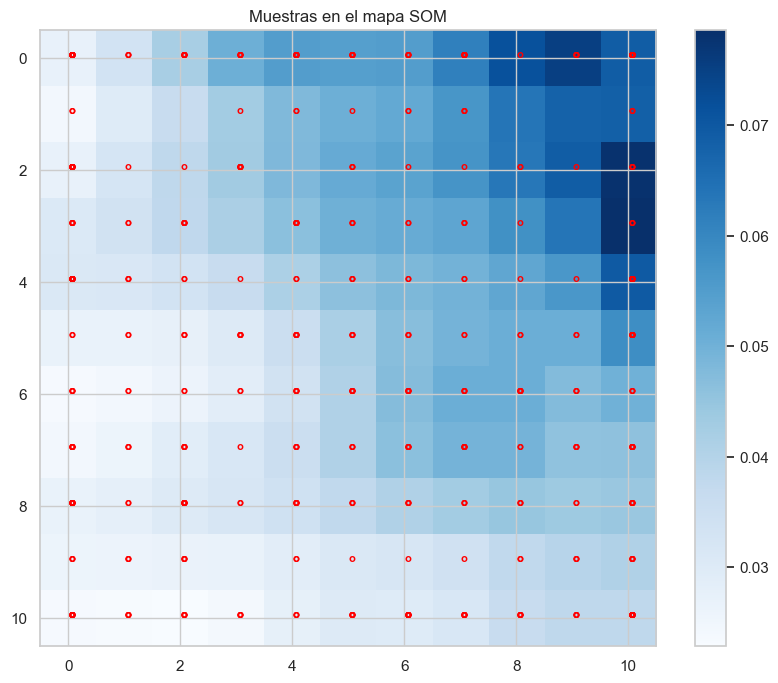

In [27]:
# Obtener las posiciones de las muestras en el mapa
mapped = som.map_vects(X_scaled)
mapped = np.array(mapped)

# Visualizar las muestras en el mapa SOM
plt.figure(figsize=(10, 8))
plt.imshow(u_matrix, cmap='Blues')
plt.colorbar()
plt.title('Muestras en el mapa SOM')

# Marcar cada muestra en el mapa
for i, (x, y) in enumerate(mapped):
    plt.text(y, x, 'o', color='red', fontdict={'weight': 'bold', 'size': 8})

plt.show()


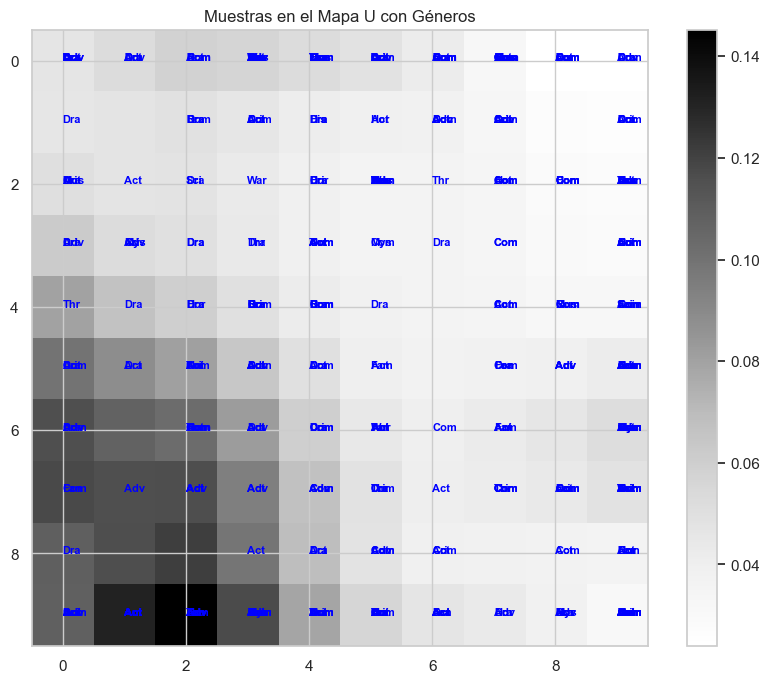

In [19]:
# Visualizar las muestras con etiquetas de género
plt.figure(figsize=(10, 8))
plt.imshow(u_matrix, cmap='Greys')
plt.colorbar()
plt.title('Muestras en el Mapa U con Géneros')

df_with_genres = df.sample(frac=0.1, random_state=42)

for idx, (x, y) in enumerate(mapped):
    genre = df_with_genres.iloc[idx]['genres']
    plt.text(y, x, genre[:3], color='blue', fontdict={'weight': 'bold', 'size': 8})

plt.show()

## 6. Mapas de Componentes

Visualizamos cómo cada característica influye en el mapa SOM.

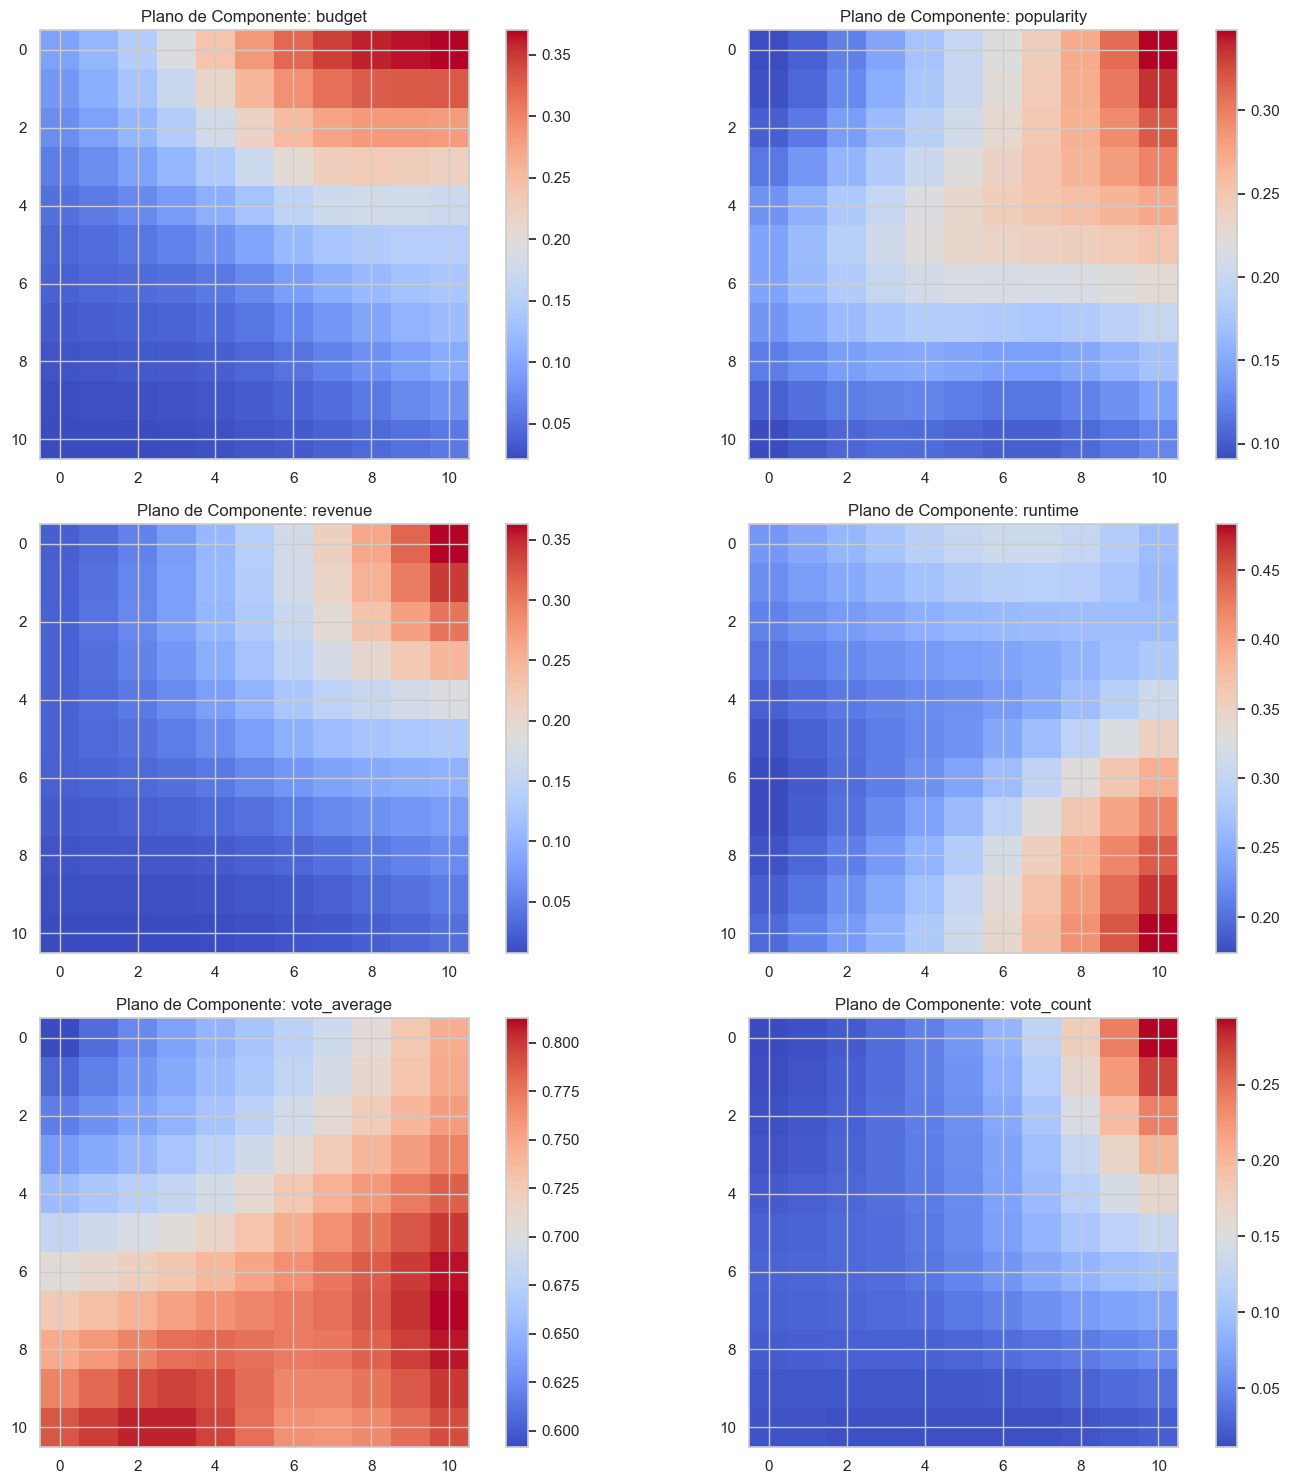

In [28]:
def plot_component_planes(som, feature_names):
    plt.figure(figsize=(15, 15))
    for i, feature in enumerate(feature_names):
        plt.subplot(3, 2, i+1)
        plane = som.weights[:, :, i]
        plt.imshow(plane, cmap='coolwarm')
        plt.colorbar()
        plt.title(f'Plano de Componente: {feature}')
    plt.tight_layout()
    plt.show()

plot_component_planes(som, numerical_features)


## 7. Creando el GIF de la evolución de la Matriz U

In [9]:
import matplotlib.animation as animation

def create_umatrix_gif(som):
    fig, ax = plt.subplots(figsize=(6, 6))

    def update(frame):
        ax.clear()
        u_matrix = som.u_matrices[frame]
        im = ax.imshow(u_matrix, cmap='Blues')
        iteration = (frame * capture_interval) + 1
        ax.set_title(f'Mapa U - Iteración {iteration}')
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=len(som.u_matrices), blit=False)
    ani.save('kohonen_outputs/umatrix_evolution.gif', writer='pillow')
    plt.close(fig)

# Create the GIF
create_umatrix_gif(som)

## 8. Análisis de Hiperparámetros y Gráficos Comparativos

### 8.1. Definición de los Valores de Hiperparámetros

In [10]:
learning_rates = [0.1, 0.3, 0.5, 0.7, 0.9]
sigmas = [0.5, 1.0, 1.5, 2.0]

### 8.2. Función para Calcular el MQE

In [11]:
def calculate_mqe(som, data):
    errors = []
    for x in data:
        bmu = som._find_bmu(x)
        bmu_weight = som.weights[bmu]
        error = np.linalg.norm(x - bmu_weight)
        errors.append(error)
    return np.mean(errors)

### 8.3. Entrenamiento y Evaluación con Diferentes Hiperparámetros

In [12]:
results = []

for lr in learning_rates:
    mqe_values = []
    for sigma in sigmas:
        som = SOM(m=m, n=n, dim=X_scaled.shape[1], sigma=sigma, learning_rate=lr, num_iterations=5000)
        som.train(X_scaled)
        mqe = calculate_mqe(som, X_scaled)
        mqe_values.append(mqe)
        print(f"Learning Rate: {lr}, Sigma: {sigma}, MQE: {mqe:.4f}")
    results.append(mqe_values)

Learning Rate: 0.1, Sigma: 0.5, MQE: 0.1077
Learning Rate: 0.1, Sigma: 1.0, MQE: 0.0801
Learning Rate: 0.1, Sigma: 1.5, MQE: 0.0775
Learning Rate: 0.1, Sigma: 2.0, MQE: 0.0789
Learning Rate: 0.3, Sigma: 0.5, MQE: 0.0910
Learning Rate: 0.3, Sigma: 1.0, MQE: 0.0611
Learning Rate: 0.3, Sigma: 1.5, MQE: 0.0551
Learning Rate: 0.3, Sigma: 2.0, MQE: 0.0584
Learning Rate: 0.5, Sigma: 0.5, MQE: 0.0905
Learning Rate: 0.5, Sigma: 1.0, MQE: 0.0546
Learning Rate: 0.5, Sigma: 1.5, MQE: 0.0515
Learning Rate: 0.5, Sigma: 2.0, MQE: 0.0552
Learning Rate: 0.7, Sigma: 0.5, MQE: 0.0773
Learning Rate: 0.7, Sigma: 1.0, MQE: 0.0376
Learning Rate: 0.7, Sigma: 1.5, MQE: 0.0428
Learning Rate: 0.7, Sigma: 2.0, MQE: 0.0538
Learning Rate: 0.9, Sigma: 0.5, MQE: 0.0880
Learning Rate: 0.9, Sigma: 1.0, MQE: 0.0378
Learning Rate: 0.9, Sigma: 1.5, MQE: 0.0427
Learning Rate: 0.9, Sigma: 2.0, MQE: 0.0547


### 8.4. Gráfico Comparativo del Impacto de los Hiperparámetros

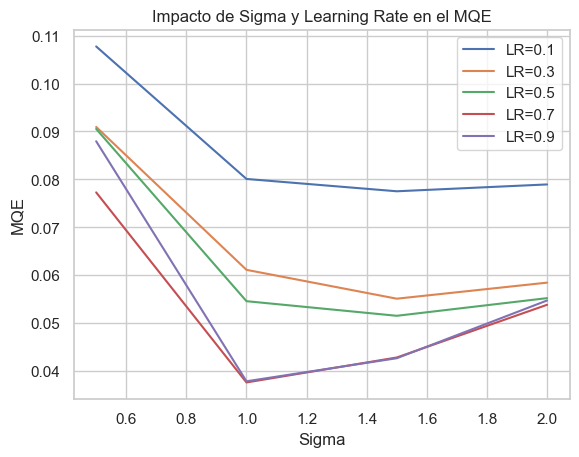

In [13]:
# Convertir los resultados en un array numpy
results = np.array(results)

# Crear un gráfico para cada learning rate
for i, lr in enumerate(learning_rates):
    plt.plot(sigmas, results[i], label=f'LR={lr}')

plt.xlabel('Sigma')
plt.ylabel('MQE')
plt.title('Impacto de Sigma y Learning Rate en el MQE')
plt.legend()
plt.show()

## 9. Análisis de Pares Únicos de Características

### 9.1. Obtener Todos los Pares Únicos de Características

In [14]:
from itertools import combinations

numerical_features = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
feature_pairs = list(combinations(numerical_features, 2))

### 9.2. Iteración Sobre Cada Par y Generación de Visualizaciones

In [15]:
for pair in feature_pairs:
    print(f"\nAnálisis para las características: {pair[0]} y {pair[1]}")

    # Extraer y escalar los datos
    X_pair = df_sample[list(pair)].values
    scaler = MinMaxScaler()
    X_scaled_pair = scaler.fit_transform(X_pair)

    # Definir un SOM de tamaño adecuado
    m, n = 10, 10  # Puedes ajustar el tamaño según tus necesidades

    # Inicializar y entrenar el SOM
    som = SOM(m=m, n=n, dim=X_scaled_pair.shape[1], sigma=1.0, learning_rate=0.5, num_iterations=5000)
    som.train(X_scaled_pair)

    # Calcular el Mapa U
    u_matrix = calculate_u_matrix(som)

    # Visualizar el Mapa U
    plt.figure(figsize=(6, 6))
    plt.imshow(u_matrix, cmap='Blues')
    plt.colorbar()
    plt.title(f'Mapa U para {pair[0]} y {pair[1]}')
    plt.savefig(f'kohonen_outputs/umatrix_{pair[0]}_{pair[1]}.png')
    plt.close()

    # Visualizar las muestras en el mapa SOM
    mapped = som.map_vects(X_scaled_pair)
    mapped = np.array(mapped)

    plt.figure(figsize=(6, 6))
    plt.imshow(u_matrix, cmap='Blues')
    plt.colorbar()
    plt.title(f'Muestras en el mapa SOM para {pair[0]} y {pair[1]}')

    for i, (x, y) in enumerate(mapped):
        plt.text(y, x, 'o', color='red', fontdict={'weight': 'bold', 'size': 8})

    plt.savefig(f'kohonen_outputs/som_muestras_{pair[0]}_{pair[1]}.png')
    plt.close()

    # Mapas de Componentes
    plt.figure(figsize=(12, 5))
    for i, feature in enumerate(pair):
        plt.subplot(1, 2, i+1)
        plane = som.weights[:, :, i]
        plt.imshow(plane, cmap='coolwarm')
        plt.colorbar()
        plt.title(f'Plano de Componente: {feature}')
    plt.tight_layout()
    plt.savefig(f'kohonen_outputs/component_planes_{pair[0]}_{pair[1]}.png')
    plt.close()


Análisis para las características: budget y popularity

Análisis para las características: budget y revenue

Análisis para las características: budget y runtime

Análisis para las características: budget y vote_average

Análisis para las características: budget y vote_count

Análisis para las características: popularity y revenue

Análisis para las características: popularity y runtime

Análisis para las características: popularity y vote_average

Análisis para las características: popularity y vote_count

Análisis para las características: revenue y runtime

Análisis para las características: revenue y vote_average

Análisis para las características: revenue y vote_count

Análisis para las características: runtime y vote_average

Análisis para las características: runtime y vote_count

Análisis para las características: vote_average y vote_count
